# Prediction of Nighttime NO2

## Background

### Names and Acronyms
1) ASDC: [Atmosperhic Science Data Center](https://asdc.larc.nasa.gov/about)
1) PGN (Pandora): [Pandonia Global Network](https://www.pandonia-global-network.org/) / [Pandora](https://pandora.gsfc.nasa.gov/About/)
    - **NOTE**: NASA's portion of the PGN is known as Pandora.  Within the scope of this notebook, Pandora and PGN may be used interchangably as this project will only use NASAs PGN site data.
1) TEMPO: [Troposoperic Emissions: Monitoring of Pollution](https://science.nasa.gov/mission/tempo/)

### Resources
1) ASDC Data Processing Tool (Version 1)
    - This notebook was published by the ASDC and provides examples of how to correctly load and use Pandora and TEMPO data.
    - https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb
1) PGN Station Map
    - A map showing the location of all PGN groundsites.
    - https://blickm.hetzner.pandonia-global-network.org/livemaps/pgn_stationsmap.png


This notebook borrows heavily from and extens the functionality of the NASA, ASDC Data and User Servicies notebook found here:

https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb

This notebook intends to test the hypothesis that a model can be built with Pandora which can predict nightitme NO<sub>2</sub> and that that model can be applied to TEMPO daytime measurments to predict NO<sub>2</sub> for any location covered by TEMPO.



## 1. Environment Setup

### Environment Setup
There are many tools available such as [poetry](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://python-poetry.org/&ved=2ahUKEwjr9aLgna6QAxX5EVkFHVsNBMUQFnoECBsQAQ&usg=AOvVaw3Jp8q7OO7XkcY8Tq4tDe30) and [uv](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://docs.astral.sh/uv/&ved=2ahUKEwiP9aXVna6QAxVyF1kFHeyTNGYQFnoECAsQAQ&usg=AOvVaw2VJVt0jrah2S9tIgdc1yRc) that simplify and speed up environment setup.  For simplicity, this guide only covers the method built into the python standard library.
1) Install [Python 3.11](https://www.python.org/downloads/) (or higher)
1) (Recomended) Create a virtual environment (learn more [here](https://docs.python.org/3/library/venv.html))
1) Install the required packages using the following command.<br>`% pip install pyproject.toml`
1) Select the newly created kernal in your notebook.
    - NOTE: this varies slightly between notebook tools, but in almost all tools you will be prompted to select a kernal upon running a cell.

### Import required modules

Common imports that are used throughout.  Other packages will be imported as needed.

In [462]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

### Data Access
In order to access data, you will need an Earthdata Login account.  If you do not have an Earthdata Login account, you can create one here:<br>
https://urs.earthdata.nasa.gov/

The earthaccess module allows you to authenticate.  Multilple login options exist for providing your credentials, you can read more on options here:<br>
https://pypi.org/project/earthaccess/<br>
By unless another option is configured, you will be prompted by your notebook to enter your credentials.

In [463]:
import earthaccess


earthaccess.login()

Notebook Settings

In [464]:
PGN_DATA_DIR = Path('pgn-data')
PGN_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
PGN_DATA_PATH = PGN_DATA_DIR.joinpath('pgn-data.csv')
TEMPO_DATA_DIR = Path('tempo-data')
TEMPO_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
TEMPO_DATA_PATH = TEMPO_DATA_DIR.joinpath('tempo-data.csv')

Optionally, clean data stores, since data is filtered by time and site, data shoudl be removed when times or sites change.

In [ ]:
# if CLEAN is True, removes all stored data.
CLEAN_PGN = True
CLEAN_TEMPO = False

if CLEAN_PGN:
    for file in PGN_DATA_DIR.iterdir():
        file.unlink()
if CLEAN_TEMPO:
    for file in TEMPO_DATA_DIR.iterdir():
        file.unlink()

## 1. Data Prepairation

### 1.1. Download Data

**Data Ingest Workflow**
1) Collect the URLs for relivant files.
1) If not already downloaded, download the files.
1) If not already parsed, parse the files and save them as dataframes.
1) Return a list of relivant file paths

**Notes**
- PGN and TEMPO files are saved to the PGN_DATA_DIR and TEMPO_DATA_DIR directories.
- This system allows new files to be added while old files are still used, when available.
- TEMPO files are VERY large, a full year of data for 3 PGN sites takes up 100GB of hard drive space.
- Running for a shorter time period does not delete data, it only uses a smaller subset of files ensuring that short time frames can be used for testing.
- Though VERY slow to run initially, subsiquent runs for the same or smaller data subsets are fairly fast.

#### 1.1.1. Define Download Settings

In [466]:
# July 21, 2024 was a full moon, which should provide high quality Lunar PGN NO2 Readings.
start_date = datetime(2024, 7, 15)
end_date = datetime(2024, 7, 25)

#### 1.1.1. Download Pandora data

Pandora settings

You can find all Pandora daytime data [here](https://data.pandonia-global-network.org), nighttime data must be acquired from the [API](https://api.hetzner.pandonia-global-network.org/docs#/).

For more information about PGN codes and columns, see the file header.

In [467]:
daytime_suffix = 'rnvh3p1-8.txt'
nightitme_suffix = 'rnvm2p1-8.txt'
pgn_formats = {
    # daytime file format
    daytime_suffix: {
        'cycle': 'Day',
        'suffix': 'rnvh3p1-8.txt',
        'no2_quality_flag_index': 52,
        'valid_quality_flags': [0, 10],
        'column_index': 61,
        'column_unc_index': 62,
    },
    # nighttime file format
    nightitme_suffix: {
        'cycle': 'Night',
        'suffix': 'rnvm2p1-8.txt',
        'no2_quality_flag_index': 35,
        'valid_quality_flags': [0, 1, 10, 11, 12],
        'column_index': 38,
        'column_unc_index': 39,
    },
}

# sites = ['BronxNY', 'BuffaloNY', 'QueensNY']
# site with known daytime and nighttime data
sites = {'WashingtonDC'}

#### 1.1.1.3 Get PGN Files

An API must be used to download the daytime and nighttime files where they exist.  Not all sites are set up to take nighttime readings.

You can read more about the API here:<br>
https://api.hetzner.pandonia-global-network.org/docs#/v1%2Ffiles/location_v1_files__location__get

For each location, search each instrument and spectrometer for applicable files.

In [468]:
import requests


BASE_URL = "https://api.ovh.pandonia-global-network.org/v1/files"
headers = {"X-API-Key": "kWKkafU6BfyO9vGQbso_o-LZYOZTL6IOaFLtdj8dIpQ"}  # Add your API key here

pgn_urls: list[str] = []
for site in sites:
    print("Processing", site)
    instruments = requests.get(f"{BASE_URL}/{site}",  headers=headers).json()
    for instrument in instruments:
        instrument_id = instrument['pan_id']
        for spectrometer in [1, 2]:
            for code in ['rnvm2', 'rnvh3']:
                url = (
                    'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?'
                    f'start_datetime={start_date.date()}&'
                    f'end_datetime={end_date.date()}&'
                    f'pan_id={instrument_id}&'
                    f'spectrometer={spectrometer}&'
                    f'location={site}&'
                    f'code={code}&blickp_version=p1-8'
                )
                response = requests.get(url, headers=headers).content.decode('utf-8')
                if response.startswith('File name:'):
                    pgn_urls.append(url)
pgn_urls

Processing WashingtonDC


['https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvm2&blickp_version=p1-8',
 'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvh3&blickp_version=p1-8']

Download files

In [469]:
# The raw PGN files
pgn_files = []
for url in pgn_urls:
    print("Processing", url)
    data = requests.get(url, headers=headers).content.decode('utf-8')
    first_line = data.split('\n', 1)[0]
    file_name = first_line.split(': ')[-1]
    # remove random code from end of file name
    file_name = "_".join(file_name.split('_')[:-1])+'.txt'
    file_path = PGN_DATA_DIR.joinpath(file_name)
    pgn_files.append(file_path)
    if file_path.exists():
        print("File exists:", file_path)
        continue
    file_path.write_text(data)
    print("File saved:", file_path)

Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvm2&blickp_version=p1-8
File saved: pgn-data\Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvh3&blickp_version=p1-8
File saved: pgn-data\Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt


Parse files into CSV format (if needed)

In [470]:
# PGN format settings (these should not change)
pgn_section_delim = f"{'-'*87}\n"
header_delim = ": "
pgn_loc_key = "Short location name"
pgn_lat_key = "Location latitude [deg]"
pgn_lon_key = "Location longitude [deg]"
# Avogadro constant divided by 10000
no2_scale = 6.02214076E+19

_sites = []
lats = []
lons = []
# the PGN dat parsed into CSV files
PGN_PATHS = []

# build the final dataset
print("Parsing PGN data started")
for i, pgn_path in enumerate(pgn_files):
    print("Processing", pgn_path)
    # get file sections as lines
    text = pgn_path.read_text()
    metadata_text, column_text, data_text = text.split(pgn_section_delim)
    metadata_lines = metadata_text.splitlines()
    data_lines = data_text.splitlines()

    # get metadata
    metadata = {}
    for line in metadata_lines:
        key, value = line.split(header_delim)
        metadata[key] = value
    
    site_lat = float(metadata[pgn_lat_key])
    site_lon = float(metadata[pgn_lon_key])
    
    _sites.append(pgn_path.name.split('_')[1])
    lats.append(site_lat)
    lons.append(site_lon)

    # if data already exists as CSV, skip parsing
    csv_path = pgn_path.with_suffix('.csv')
    if csv_path.exists():
        print("\tFile already parsed, skipping")
        PGN_PATHS.append(csv_path)
        continue

    # get data
    file_suffix = pgn_path.name.split('_')[-1]
    file_format = pgn_formats[file_suffix]
    no2_quality_flag_index = file_format['no2_quality_flag_index']
    valid_quality_flags = file_format['valid_quality_flags']
    column_index = file_format['column_index']
    unc_index = file_format['column_unc_index']

    rows = []
    for line in data_lines:
        values = line.split()
        # convert timestamps
        timestamp = datetime.fromisoformat(values[0]).replace(tzinfo=None)

        # filtering low quality records
        if int(values[no2_quality_flag_index]) not in valid_quality_flags:
            continue

        row = {
            'Time': timestamp,
            'Latitude': site_lat,
            'Longitude': site_lon,
            'Column': float(values[column_index])*no2_scale,
            'Uncertainty': float(values[unc_index])*no2_scale,
            'Site': metadata[pgn_loc_key],
            'Cycle': file_format['cycle']
        }
        rows.append(row)

    # convert rows into a dataframe
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(csv_path, index=False)
        PGN_PATHS.append(csv_path)
        print(f"\tValid Observations: {len(rows)}")
    else:
        print("\tWARNING: No rows in file, skipping.")

# create site metadata dataframe
sites_df = pd.DataFrame({
    'Site': _sites,
    'Latitude': lats,
    'Longitude': lons
}).set_index('Site').drop_duplicates()

print("Parsed", len(PGN_PATHS), "PGN files")
sites_df


Parsing PGN data started
Processing pgn-data\Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
	Valid Observations: 999
Processing pgn-data\Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt
	Valid Observations: 524
Parsed 2 PGN files


,Latitude,Longitude
Site,,
WashingtonDC,38.9218,-77.0124


Get latitudes and longitudes (for use with TEMPO download)

#### 1.1.1 Download TEMPO Data

Get relivant TEMPO files.

In [471]:
short_name = 'TEMPO_NO2_L2' # collection name to search for in the EarthData
out_Q = 'NO2_trop_col_day'
version = 'V03'

cloud_files = []
for site, site_lat, site_lon in sites_df.itertuples():
    cloud_files += earthaccess.search_data(
        short_name = short_name,
        version = version,
        temporal = (start_date, end_date),
        point = (site_lon, site_lat)
    )

print("Found", len(cloud_files), "data collections containing the sites.")

Found 122 data collections containing the sites.


Download files (if needed)

In [472]:
import warnings

# this error comes from netCDF4 and is only a warning and can be ignored
warnings.filterwarnings(
    "ignore",
    message="__array__ implementation doesn't accept a copy keyword",
    category=DeprecationWarning,
)

nc_paths: list[Path] = []
for i, cloud_file in enumerate(cloud_files):
    # download files if a file with the same name is not found in the download directory
    paths = earthaccess.download(cloud_file, local_path=TEMPO_DATA_DIR, show_progress=False)
    nc_paths += paths

print("Downloaded", len(nc_paths), "files.")

Downloaded 122 files.


Parse TEMPO files into CSV format (if needed)

In [473]:
import netCDF4 as nc

# only keep measurments within offset of a site
offset = 0.1

TEMPO_FILES = []
col_names = ['Time', 'Latitude', 'Longitude', 'Column', 'Uncertainty', 'Site', 'System']

for path in nc_paths:
    csv_path = path.with_suffix('.csv')
    # skip if file already exists
    if csv_path.exists():
        TEMPO_FILES.append(csv_path)
        continue

    file_time = datetime.fromisoformat(path.name.split('_')[4]).replace(tzinfo=None)
    with nc.Dataset(path) as ds:
        geolocation = ds['geolocation']
        product = ds['product']
        col_var = product['vertical_column_troposphere']
        unc_var = product['vertical_column_troposphere_uncertainty']

        col_fil = col_var.getncattr('_FillValue')
        unc_fil = unc_var.getncattr('_FillValue')

        lats = np.array(geolocation['latitude']).flatten()
        lons = np.array(geolocation['longitude']).flatten()
        cols = np.array(col_var).flatten()
        uncs = np.array(unc_var).flatten()

    num_records = len(lats)
    times = np.full((num_records), fill_value=file_time)
    systems = np.full((num_records), fill_value='TEMPO')

    data = {
        'Time': times,
        'Latitude': lats,
        'Longitude': lons,
        'Column': cols,
        'Uncertainty': uncs,
    }
    df = pd.DataFrame(data)

    df.to_csv(csv_path, index=False)
    TEMPO_FILES.append(csv_path)

print("Parsed", len(TEMPO_FILES), "files.")

Parsed 122 files.


PGN_FILES and TEMPO_FILES have been populdated with analysis ready data.

### 1.2. Explore Data

After download, analysis ready data must be loaded from CSVs into TEMPO and PGN data dataframs.  Once in dataframes, data can be explored, cleaned, and transformed to ready it for modeling.

#### 1.2.1 Load Pandora

Load Pandora Data

In [486]:
pgn_df = pd.concat([pd.read_csv(p, parse_dates=['Time']) for p in PGN_PATHS], ignore_index=True)
print("PGN Data Shape:", pgn_df.shape)
pgn_df.sample(5)


PGN Data Shape: (1523, 7)


,Time,Latitude,Longitude,Column,Uncertainty,Site,Cycle
306,2024-07-18 06:10:45.500,38.9218,-77.0124,-4.743219e+16,8.688142e+12,WashingtonDC,Night
1380,2024-07-21 19:55:28.600,38.9218,-77.0124,9.401164e+15,7.942601e+13,WashingtonDC,Day
468,2024-07-20 03:36:47.800,38.9218,-77.0124,1.149687e+16,3.190470e+14,WashingtonDC,Night
705,2024-07-22 02:17:57.200,38.9218,-77.0124,8.563484e+15,1.358896e+15,WashingtonDC,Night
550,2024-07-21 01:01:25.300,38.9218,-77.0124,1.304034e+16,5.360548e+15,WashingtonDC,Night


#### Explore Data

In [487]:
print("Start Time:", pgn_df.Time.min())
print("End Time:", pgn_df.Time.max())
pgn_df.describe()

Start Time: 2024-07-15 00:31:15.100000
End Time: 2024-07-24 22:09:30.900000


,Time,Latitude,Longitude,Column,Uncertainty
count,1523,1.523000e+03,1.523000e+03,1.523000e+03,1.523000e+03
mean,2024-07-20 01:36:37.393828096,3.892180e+01,-7.701240e+01,-5.693948e+117,6.594117e+18
min,2024-07-15 00:31:15.100000,3.892180e+01,-7.701240e+01,-5.419927e+119,-5.419927e+20
25%,2024-07-18 01:01:48.600000,3.892180e+01,-7.701240e+01,1.875144e+15,3.826920e+13
50%,2024-07-20 04:38:57.700000,3.892180e+01,-7.701240e+01,5.862494e+15,7.737246e+13
75%,2024-07-22 04:48:06.049999872,3.892180e+01,-7.701240e+01,1.242940e+16,8.683325e+14
max,2024-07-24 22:09:30.900000,3.892180e+01,-7.701240e+01,1.634108e+19,1.731125e+22
std,NaN,7.107761e-15,1.421552e-14,5.527805e+118,4.479260e+20


First we'll need to filter data by the sptaial (lat/lon) and temporal (time) range.  The sptial range should be fine since data are tied to ground sites, while the time range covers a far longer time period than we're looking at here.

**Future Work**<br>
- Since the dataset is relatively small, consider building a model based on the entire dataset for the desired sites, then only download TEMPO data for the desired days.

#### Temporal Filtering

In [476]:
temporal_mask = (start_date < pgn_df.Time) & (pgn_df.Time < end_date)
pgn_df = pgn_df[temporal_mask]
print("Start Time:", pgn_df.Time.min())
print("End Time:", pgn_df.Time.max())
pgn_df.describe()

Start Time: 2024-07-15 00:31:15.100000
End Time: 2024-07-24 22:09:30.900000


,Time,Latitude,Longitude,Column,Uncertainty
count,1523,1.523000e+03,1.523000e+03,1.523000e+03,1.523000e+03
mean,2024-07-20 01:36:37.393828096,3.892180e+01,-7.701240e+01,-5.693948e+117,6.594117e+18
min,2024-07-15 00:31:15.100000,3.892180e+01,-7.701240e+01,-5.419927e+119,-5.419927e+20
25%,2024-07-18 01:01:48.600000,3.892180e+01,-7.701240e+01,1.875144e+15,3.826920e+13
50%,2024-07-20 04:38:57.700000,3.892180e+01,-7.701240e+01,5.862494e+15,7.737246e+13
75%,2024-07-22 04:48:06.049999872,3.892180e+01,-7.701240e+01,1.242940e+16,8.683325e+14
max,2024-07-24 22:09:30.900000,3.892180e+01,-7.701240e+01,1.634108e+19,1.731125e+22
std,NaN,7.107761e-15,1.421552e-14,5.527805e+118,4.479260e+20


Check for missing values

In [477]:
pgn_df.isna().sum()

Time           0
Latitude       0
Longitude      0
Column         0
Uncertainty    0
Site           0
Cycle          0
dtype: int64

There's no missing data to drop.  Next we'll look at the data.

<Axes: title={'center': 'NO2 Column vs Time'}, xlabel='Time', ylabel='Column'>

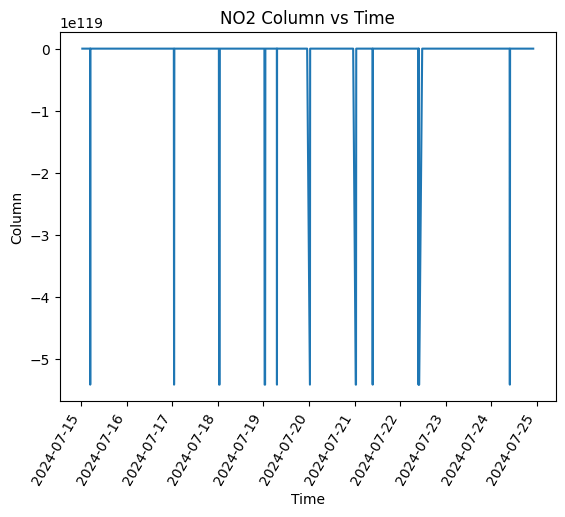

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.xticks(rotation=60, ha='right')
plt.title("NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.lineplot(data=pgn_df, x='Time', y='Column')

Lets remove negative values, they seem to be otuliers.

<Axes: title={'center': 'NO2 Column vs Time'}, xlabel='Time', ylabel='Column'>

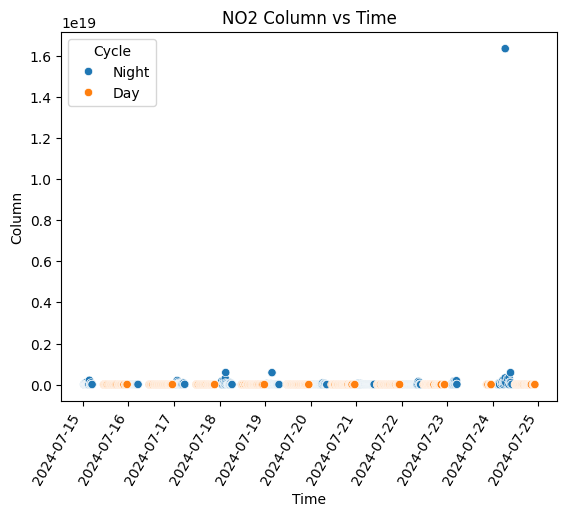

In [ ]:
negative_filter = pgn_df.Column > 0
pgn_df = pgn_df[negative_filter]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

It seems that the outliers of nighttime and daytime data are on vary different scales.  Lets calculate and remove outliers on a per dataset basis.

<Axes: title={'center': 'NO2 Column vs Time'}, xlabel='Time', ylabel='Column'>

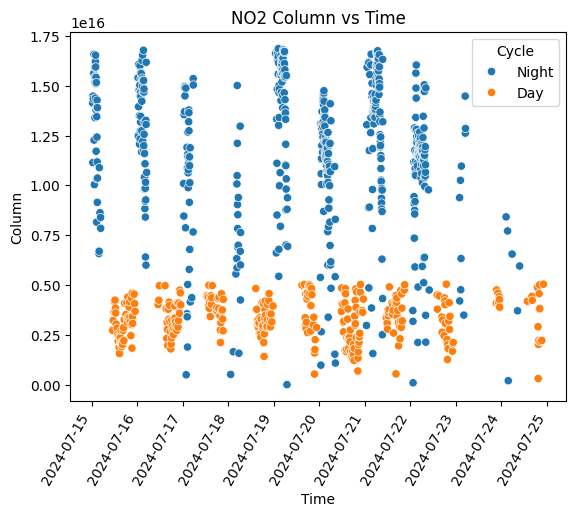

In [ ]:
from matplotlib import pyplot as plt


# 3, 2, and 1 were tried, 1 offered the best results
outlier_stds = 1

# get daytime mask
day_mask = pgn_df.Cycle == 'Day'
night_mask = pgn_df.Cycle == 'Night'

day_mean = pgn_df[day_mask].Column.mean()
day_std = pgn_df[day_mask].Column.std()
day_cutoff = day_mean + (day_std * outlier_stds)
day_outlier_mask = night_mask | (pgn_df.Column < day_cutoff)

night_mean = pgn_df[night_mask].Column.mean()
night_std = pgn_df[night_mask].Column.std()
night_cutoff = night_mean + (night_std * outlier_stds)
night_outlier_mask = day_mask | (pgn_df.Column < night_cutoff)

outlier_mask = day_outlier_mask & night_outlier_mask

pgn_df = pgn_df[outlier_mask]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("NO2 Column vs Time")
plt.xlabel('Time (UTC)')
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

Here, we see somewhat consistant coverage over the day.  Unfortunatly, since Lunear NO2 readings require moon visability, the quality, quantity, and coverage of nightitme readings varies significantly.  

To better understand the cyclical nature of the data, lets try plotting vs time of day, effectivly overlaying one day on top of the next to see if this helps to show the day night cycle trend.

<Axes: title={'center': 'NO2 Column vs Time of Day'}, xlabel='Hour of Day (UTC)', ylabel='Column'>

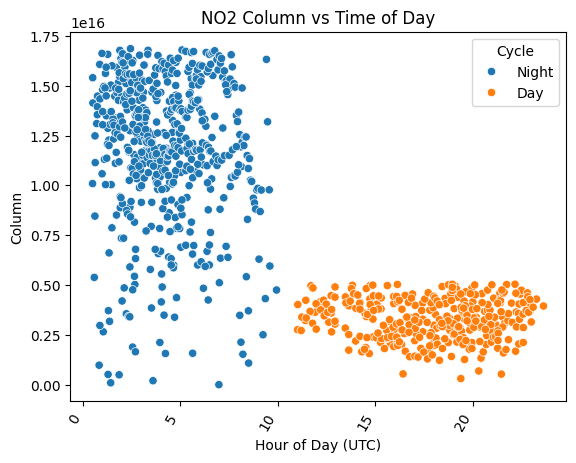

In [505]:
# convert to seconds since the linux epoch then get the remainder after deviding the seconds in a day to get time of day in seconds
pgn_df['TimeOfDay'] = (pgn_df.Time.astype(int) / 10**9) % 86400
pgn_df['MinOfDay'] = pgn_df['TimeOfDay'] / 60
pgn_df['HourOfDay'] = pgn_df['MinOfDay'] / 60

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title("NO2 Column vs Time of Day")
plt.xlabel('Hour of Day (UTC)')
sns.scatterplot(data=pgn_df, x='HourOfDay', y='Column', hue='Cycle')

Times are in UTC, so 0 is 8 PM Eastern Time.  There seems to be a No2 dieoff overnight

#### Load TEMPO

In [481]:
# raise Exception("This function takes too long to run")
# select the number of samples to take (as data gets far too large to process on a single machine), also sort in terms of time
tempo_df = pd.concat([pd.read_csv(p, engine="pyarrow") for p in TEMPO_FILES], ignore_index=True).sort_values('Time')
print("TEMPO Data Shape:", tempo_df.shape)
tempo_df.head()

TEMPO Data Shape: (32702464, 5)


,Time,Latitude,Longitude,Column,Uncertainty
0,2024-07-15 10:51:22,58.780323,-63.974617,-1.000000e+30,-1.000000e+30
178850,2024-07-15 10:51:22,40.360250,-78.981220,5.156266e+15,2.239823e+15
178851,2024-07-15 10:51:22,40.340595,-78.985000,3.319422e+15,1.838431e+15
178852,2024-07-15 10:51:22,40.320450,-78.988990,2.277413e+15,8.035236e+14
178853,2024-07-15 10:51:22,40.300370,-78.992960,4.704493e+15,1.737394e+15


It looks like there might be some outliers.  To handle them I'll remove values that are more than 3 standard deviations above and values that are negative.

<Axes: xlabel='Time', ylabel='Column'>

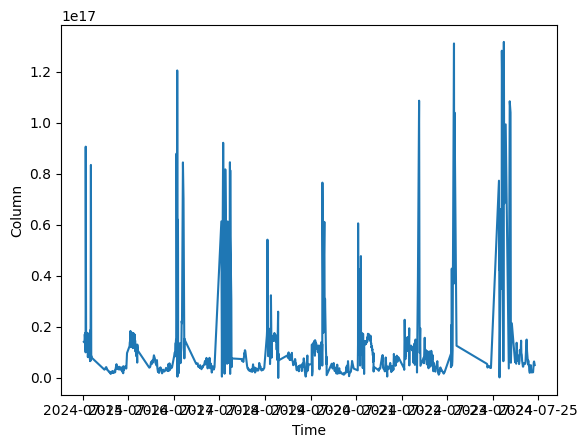

In [482]:
cutoff = pgn_df.Column.mean() + (pgn_df.Column.std() * 3)
outlier_mask = pgn_df.Column < cutoff
negative_mask = pgn_df.Column > 0
pgn_df = pgn_df[outlier_mask & negative_mask]
sns.lineplot(data=pgn_df.sample(1000), x='Time', y='Column')

### 1.3. Clean Data

#### 1.3.1 Clean Pandora 

**Future Work**<br>
For now I only use raw data with outliers removed.  Consider performing the following steps to further normalize datasets.
1) Seasonal Composition
1) Standardized Data

In [483]:
def get_outlier_mask(column: pd.Series) -> pd.Series:
    """
    Returns a mask where outliers are False for use in filtering outliers.
    Outliers are defined as more than 3 standard deviations from the mean.
    Intended for use in filtering out outliers.
    use: 
        mask = get_outlier_mask(df.ColumnOfIntrest)
        df = df[mask]

    ARGS:
        column (pd.Series[float]): the column to build a mask for
    
    RETURN
        pd.Series[bool]: A mask of the outliers
    """
    col_std = column.std()
    col_mean = column.mean()
    min_cutoff = col_mean - (3 * col_std)
    max_cutoff = col_mean + (3 * col_std)
    return (min_cutoff < column) & (column < max_cutoff)

Raw Data Cleaning

In [484]:
col_mask = get_outlier_mask(pgn_data.Column)
unc_mask = get_outlier_mask(pgn_data.Uncertainty)
mask = col_mask & unc_mask

print("Filtering", sum(~mask), "rows of", len(mask), f"due to outliers, {round(sum(~mask)/len(mask)*100)}%")
pgn_clean_data = pgn_data[mask]
pgn_clean_data.head()

NameError: name 'pgn_data' is not defined

#### 1.3.2 Clean TEMPO

### 1.4. Transform Data

In [ ]:
col_mask = get_outlier_mask(tempo_data.Column)
unc_mask = get_outlier_mask(tempo_data.Uncertainty)
mask = col_mask & unc_mask

print("Filtering", sum(~mask), "rows of", len(mask), f"due to outliers, {round(sum(~mask)/len(mask)*100)}%")
tempo_clean_data = tempo_data[mask]
tempo_clean_data.head()

Filtering 122548 rows of 4472012 due to outliers, 3%


,Time,Latitude,Longitude,Column,Uncertainty
0,1.403866e+09,58.582800,-64.220375,5.018798e+14,1.366402e+14
1,1.403866e+09,58.536476,-64.263855,6.264613e+14,2.370017e+14
2,1.403866e+09,58.496826,-64.299690,6.328754e+14,2.307473e+14
3,1.403866e+09,58.458267,-64.334200,3.225646e+14,3.939703e+14
4,1.403866e+09,58.421070,-64.367096,2.493699e+14,2.303265e+14


Compare clean data

In [ ]:
clean_compare_df = pgn_clean_data[['Column', 'Uncertainty']].describe().join(
    tempo_clean_data[['Column', 'Uncertainty']].describe(),
    lsuffix='_PGN',
    rsuffix='_TEMPO'
)
clean_compare_df

,Column_PGN,Uncertainty_PGN,Column_TEMPO,Uncertainty_TEMPO
count,1.303100e+04,1.303100e+04,4.349464e+06,4.349464e+06
mean,5.773519e+15,9.517311e+13,1.092413e+15,1.106714e+15
std,4.212874e+15,2.234539e+13,1.393054e+15,9.597021e+14
min,-9.081990e+15,3.743784e+13,-5.380277e+15,1.066555e+14
25%,2.513069e+15,7.985961e+13,2.308500e+14,5.281086e+14
50%,4.743219e+15,9.366838e+13,7.939537e+14,7.705515e+14
75%,7.877863e+15,1.073386e+14,1.648714e+15,1.267311e+15
max,2.237526e+16,1.823444e+14,7.897732e+15,6.365967e+15


Git differences between raw and clean data comparison

In [ ]:
raw_compare_df

,Column_PGN,Uncertainty_PGN,Column_TEMPO,Uncertainty_TEMPO
count,1.337700e+04,1.337700e+04,4.472012e+06,4.472012e+06
mean,6.289382e+15,9.779774e+13,1.257430e+15,1.291481e+15
std,5.370501e+15,2.841439e+13,2.213436e+15,1.691506e+15
min,-1.635613e+16,3.743784e+13,-1.166274e+17,1.066555e+14
25%,2.565372e+15,8.028718e+13,2.362738e+14,5.334135e+14
50%,4.886726e+15,9.432479e+13,8.152280e+14,7.879533e+14
75%,8.262979e+15,1.087478e+14,1.723481e+15,1.346081e+15
max,5.084433e+16,4.669327e+14,2.927148e+17,2.446642e+17


In [ ]:
clean_compare_df

,Column_PGN,Uncertainty_PGN,Column_TEMPO,Uncertainty_TEMPO
count,1.303100e+04,1.303100e+04,4.349464e+06,4.349464e+06
mean,5.773519e+15,9.517311e+13,1.092413e+15,1.106714e+15
std,4.212874e+15,2.234539e+13,1.393054e+15,9.597021e+14
min,-9.081990e+15,3.743784e+13,-5.380277e+15,1.066555e+14
25%,2.513069e+15,7.985961e+13,2.308500e+14,5.281086e+14
50%,4.743219e+15,9.366838e+13,7.939537e+14,7.705515e+14
75%,7.877863e+15,1.073386e+14,1.648714e+15,1.267311e+15
max,2.237526e+16,1.823444e+14,7.897732e+15,6.365967e+15


Filtering did not change the disparity between Uncertainty, it cannot be considered for now.  TEMPO numbers seem to be consistantly a bit lower, but this may be due to the fact that TEMPO data is only collected durrind daylight hours.  For now I will use both to build a model.

**Future Work**
Investigate difference in PGN and TEMPO readings.

## 2. Data Modeling

### 2.1 Data Prep

In [ ]:
all_data = pd.concat([pgn_clean_data, tempo_clean_data])
all_data.head()

,Time,Latitude,Longitude,Location,Column,Uncertainty
0,1.719842e+09,43.0015,-78.7869,BuffaloNY,7.549356e+14,1.135294e+14
1,1.719846e+09,43.0015,-78.7869,BuffaloNY,7.286790e+14,1.090429e+14
2,1.719847e+09,43.0015,-78.7869,BuffaloNY,4.645178e+14,1.056524e+14
3,1.719848e+09,43.0015,-78.7869,BuffaloNY,6.737571e+14,1.039542e+14
4,1.719849e+09,43.0015,-78.7869,BuffaloNY,4.410074e+14,1.003108e+14


In [ ]:
all_data.describe()

,Time,Latitude,Longitude,Column,Uncertainty
count,4.362495e+06,4.362495e+06,4.362495e+06,4.362495e+06,4.362495e+06
mean,1.404901e+09,3.533997e+01,-7.798717e+01,1.106396e+15,1.103693e+15
std,1.831755e+07,1.135126e+01,3.389115e+00,1.432855e+15,9.598571e+14
min,1.403866e+09,1.733732e+01,-8.383506e+01,-9.081990e+15,3.743784e+13
25%,1.403876e+09,2.550596e+01,-8.045638e+01,2.325918e+14,5.263882e+14
50%,1.403890e+09,3.436251e+01,-7.847244e+01,7.975274e+14,7.687020e+14
75%,1.403908e+09,4.451519e+01,-7.622627e+01,1.658236e+15,1.264721e+15
max,1.760807e+09,5.863553e+01,-6.396864e+01,2.237526e+16,6.365967e+15


Convert time to Time of Day

In [ ]:
seconds_per_day = 86400
seconds_since_start_of_day = all_data.Time % seconds_per_day
all_data['TimeOfDay'] = seconds_since_start_of_day.astype(int)

For simplicity (and due to a file format issue that can be fixed later), times will be ignored.

**Future Work**<br>
Use time of day as a feature

Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_cols = ['Time', 'Latitude', 'Longitude']
X = all_data[X_cols]
y = all_data['Column']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### 2.2 Train Models

In [ ]:
from sklearn.linear_model import LinearRegression


# train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 2.2 Test Models

In [ ]:
from sklearn.metrics import mean_squared_error


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error (MSE): {np.sqrt(mse):.2e}")

Root Mean Squared Error (MSE): 1.38e+15


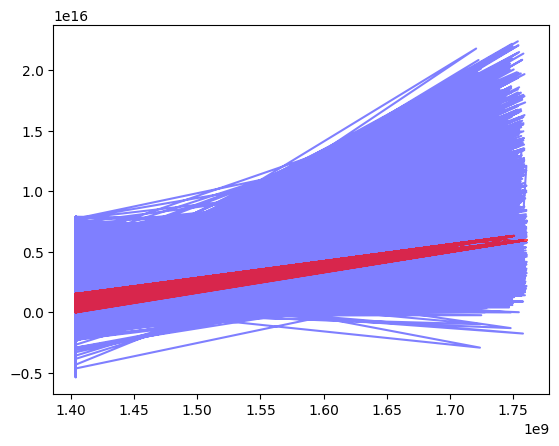

: 

In [ ]:
# --- 7. Plotting Results (Actual vs. Predicted) ---
from matplotlib import pyplot as plt



# Plot training data
plt.plot(X_test.Time, y_test, color='blue', alpha=0.5, label='Training Data (y_train)')

# Plot testing data
plt.plot(X_test.Time, y_pred, color='red', alpha=0.7, label='Testing Data (y_test)')

### 2.3. Model Visualization